# Naive approach

This file is the implementation of the "naive" approach. According to our expert, the data follows an exponential formula being $-k * e^((-1/tau)*x) + k$. We fit the parameter k and tau on existing data. These parameter are fitted for each slope occuring in the data. Therefore, we plot the parameters per difference in input and fit a quadratic or exponential function therefore.

With these functions, we can detect the parameters k and tau before the experiment by using the differences in input. Having k and tau we can put them back in the exponential formulas providing a first approximation.

## Preliminaries

In [1]:
#need the following specification, so all tables are left and not centered

In [2]:
%%html
<style>
    table {float:left}
</style>

### Import libraries

In [3]:
# own libraries
import Global_Functions as gf
import Data_Processing as dp
#python libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import metrics
import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

In [4]:
np.random.seed(123)

### Open data

In [5]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [6]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [7]:
experiments = [ex_1, ex_4, ex_9, ex_20, ex_21, ex_22, ex_23, ex_24]
names = ['1', '4', '9', '20', '21','22', '23', '24']

In [8]:
#this is needed, to apply the same name for every experiment which differ due to the preprocessing
for exp in experiments:
    spin_head = exp.filter(regex = ("spin.*"))
    exp['spin_power'] = spin_head

In [9]:
# OPEN_SYNTHETIC = 'C:/Users/FlorianLeiser/Documents/Masterarbeit/Data/Synthetic_Data/Without_Noise/Sample_Ratio_1/quadratic_12_34_linear_1'

In [10]:
# experiments = gf.load_synthetic(OPEN_SYNTHETIC, length = 20)
# names = [str(x+1) for x in range(len(experiments)-1)]
# names.append("hand")

### Specify saving folder

In [11]:
image_path = "../Images/Naive_Approach/"
image_folder = image_path + timestr +"/"
gf.check_folder(image_folder)

Creation of directory ../Images/Naive_Approach/2021-05-13_08-40/ successful.


In [12]:
train = "20"
val = "21"

#train_exs = experiments[8:10]
ex_train = ex_20#gf.use_multiple_experiments(train_exs)
ex_val = ex_21#gf.use_multiple_experiments(experiments[10:15])
#ex_test = #gf.use_multiple_experiments(experiments[15:20])

## Stationary parameters

One possibility is to use known parameters for power and spinning according to the corresponding input. With this simple approximation we ignore transition phases. We use them to show our naive approach is still better than just the stationary fit.

In [13]:
def stationary_fit(experiment):
    fit_voltage = [3,5,7.5, 10]
    fit_spin = [3103, 3250, 3604, 3961]
    fit_el = [1200, 1637, 2509, 3300]
    fit_th = [10480, 11700, 14700, 18690]

    prm_fit_st_th, pcov_th = scipy.optimize.curve_fit(gf.quadr_func, fit_voltage, fit_th, maxfev = 3000)
    prm_fit_st_el, pcov_el = scipy.optimize.curve_fit(gf.quadr_func, fit_voltage, fit_el, maxfev = 3000)
    prm_fit_st_spin, pcov_spin = scipy.optimize.curve_fit(gf.quadr_func, fit_voltage, fit_spin, maxfev = 3000)
    
    p1, p2, p3 = prm_fit_st_th
    experiment['th_pred'] = gf.quadr_func(experiment['input_voltage'], p1, p2, p3)
    p1, p2, p3 = prm_fit_st_el
    experiment['el_pred'] = gf.quadr_func(experiment['input_voltage'], p1, p2, p3)
    p1, p2, p3 = prm_fit_st_spin
    experiment['spin_pred'] = gf.quadr_func(experiment['input_voltage'], p1, p2, p3)
    
    return experiment

## Methods for approximation

In [14]:
# approximate values by using the exponential function. Adapt if necessary
def approximation(time, values):
    assert len(time) == len(values), 'time and values should have the same length'
    segment_start_value = values[0]
    param_bounds = ([-np.inf, -np.inf], [np.inf, np.inf])
    para_fit, pcov = scipy.optimize.curve_fit(gf.exp_func, time - time[0], values- segment_start_value, bounds=param_bounds, maxfev = 3000000)
    k_best = para_fit[0]
    tau_best = para_fit[1]
    return k_best, tau_best

In [15]:
def all_approximations(data_time, data_input, data_value, time_splits):
#     fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
#     axs = axs.ravel()
    approximations = np.full(shape = len(data_time), fill_value= np.nan)
    parameters = []
    
    start = time.time()
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = np.array(data_time[cut_point_prior:cut_point_post])
        value_segment = np.array(data_value[cut_point_prior:cut_point_post])
        input_start = data_input[cut_point_prior]
        input_end = data_input[cut_point_post -1]
       
        k_best, tau_best = approximation(time_segment,
                                  value_segment)
        segment_approximation = gf.exp_func(time_segment-time_segment[0], k_best, tau_best) + value_segment[0]
        approximations[cut_point_prior:cut_point_post] = segment_approximation
        prs = [input_start, input_end, k_best, tau_best]
        parameters = np.concatenate((parameters, prs), axis = 0)
        
#         axs[t].plot(time_segment, value_segment)
#         axs[t].plot(time_segment, segment_approximation)
        
        
    end = time.time()
    duration = end - start
#     axs[-1].plot(data_time, data_value)
#     axs[-1].plot(data_time, approximations)
    
    return approximations, parameters.reshape(len(time_splits) -1, 4), duration

In [16]:
def get_time_splits(df):
    time_splits = [x for x in range(len(df)-1) if df.iloc[x]['input_voltage'] != df.iloc[x+1]['input_voltage']]
    if len(time_splits) > 20:
        time_splits = time_splits[::2]
    time_splits.append(len(df))
    if time_splits[0] != 0:
        time_splits.insert(0,0)
    return time_splits

## Comparison of fits 

We compare all experiments according to their fits. This was initially done to compare the exponential fit to the stationary fit. We discovered that in all experiments the exponential fit is far better than the stationary fit. Therefore, we focused on improving the fit by includign the modelling of the fitting parameters.

Comparison of the approaches and fits compared to true values:

Variable|Approach|RMSE|R^2|MAE|MaxAE
---|----|----:|----:|---:|---:
**Spinning**|**exponential**|**37.264**|**0.987**|**23.183**|**129.704**
Spinning|stationary|210.845|0.570|98.725|868.402
**Electric**|**exponential**|**109.274**|**0.982**|**72.463**|**375.395**
Electric|stationary| 518.049|0.589|239.259|2166.749
**Thermal**|**exponential**|**1105.615**|**0.882**|**925.458**|**3662.547**
Thermal|stationary|2444.558|0.423|1618.027|10083.339

In [17]:
def compare_fits(experiment, name, images = False):
    #values = ['spin', 'el', 'th']
    values = ['el']
    parameters = []
    duration = []
    
    time_splits = get_time_splits(experiment)
    
    experiment = stationary_fit(experiment)
    
    for n in values:
        experiment[str(n + '_approx')], pms, dur = all_approximations(experiment['time'], experiment['input_voltage'], experiment[str(n +'_power')], time_splits)
        parameters.append(pms)
        duration.append(dur)
        
        if images:
            fig, axs = plt.subplots(figsize = (15,10))
            line1, = axs.plot(experiment['time'], experiment[str(n +'_power')], color = gf.get_color('grey'), label = 'true')
            line2, = axs.plot(experiment['time'], experiment[str(n +'_approx')], color = gf.get_color('orange'), label = 'exponential fit')
            line3, = axs.plot(experiment['time'], experiment[str(n +'_pred')], color = gf.get_color('cyan'), label = 'stationary fit')
            axs.set_title('Comparison of fits on ' + n + ' on ' + name, fontsize = 25)
            axs.set_xlabel('time [sec]', fontsize = 18)
            axs.set_ylabel(n , fontsize = 18)
            axs.legend([line1, line2, line3], ['true', 'exponential fit', 'stationary fit'], loc = 'upper right')

            fig.savefig(image_folder + name + "_" + n + "_fits.png")
            fig.savefig(image_folder + name + "_" + n + "_fits.svg")
        
        print('-------------- Differences on ' + name + ' ' + n + ' stationary fit----------------')
        gf.measure_difference(experiment[str(n + '_power')], experiment[str(n + '_pred')])
        print('-------------- Differences on ' + name + ' ' + n + ' exponential fit ----------------')
        gf.measure_difference(experiment[str(n + '_power')], experiment[str(n + '_approx')])        

        
    return parameters, duration

In [18]:
# # compare all parameters on stationary and exponetial fits
# all_parameters = []
# all_durations = []
# for i in range(len(experiments)):
#     prms, durs = compare_fits(experiments[i], names[i], images = True)
#     all_parameters.append([prms])
#     all_durations.append([durs])

# Meta Model
Since the exponential fits show promising results we decided to try to predict the fits. We did so by fitting one existing experiment and mapping the parameters k and tau of each slope to the according difference in input. We found the best describing function for this mapping with the information of our expert, that the stationary phases (k) have quadratic terms and the steepness (tau) is linear.

In [19]:
def df_out_of_fitting_parameters(params):
    df_params = pd.DataFrame(params)
    df_params.columns = ['input_start', 'input_end', 'k_best', 'tau_best']
    df_params['Input_diff'] = [df_params.iloc[x]['input_end'] - df_params.iloc[x]['input_start'] for x in range(len(df_params))]
    return df_params

In [20]:
def parameter_modelling(df_params, func_k, func_tau, name, images = False):
    prm_fit_k, pcov_k = scipy.optimize.curve_fit(func_k, df_params['Input_diff'], df_params['k_best'])
    prm_fit_tau, pcov_tau = scipy.optimize.curve_fit(func_tau, df_params['Input_diff'], df_params['tau_best'])
    
    tau1, tau2, tau3 = prm_fit_tau
    k1, k2 = prm_fit_k
    
    input_default = np.arange(-7.0, 7.0, 0.2)
    
    if images:
        fig,axs = plt.subplots(1, 2, figsize = (8,5))
        axs = axs.ravel()
        axs[1].scatter(df_params['Input_diff'], df_params['tau_best'], label = 'tau')
        axs[1].plot(input_default, func_tau(input_default, tau1, tau2, tau3), color = gf.get_color('orange'))
        axs[1].set_title('tau over input difference for ' + name)
        axs[1].set_ylabel('tau')
        axs[1].set_xlabel('input difference')
        axs[0].scatter(df_params['Input_diff'], df_params['k_best'], label ='k')
        axs[0].plot(input_default, func_k(input_default, k1, k2), color = gf.get_color('orange'))
        axs[0].set_title('k over input difference for ' + name)
        axs[0].set_ylabel('k')
        axs[0].set_xlabel('input difference')

        plt.savefig(image_folder + name + "_k_tau.png")
        plt.savefig(image_folder + name + "_k_tau.svg")
    
    return prm_fit_k, prm_fit_tau

In [21]:
def train_meta_modell(train_experiment, train_name):
    parameters, dur = compare_fits(train_experiment, train_name)
    #name_categories = ['_spin', '_electric', '_thermal']
    name_categories = "_electric"
    models = []
    for i in range(len(parameters)):
        df_p = df_out_of_fitting_parameters(parameters[i])
        mod = parameter_modelling(df_p, gf.linear_func, gf.quadr_func, name_categories[i], images = True)
        models.append(mod)
    return models

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Global_Functions.py:126: RuntimeWarning: overflow encountered in exp
  return -k* np.exp((-1/tau)*x) +k
C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Global_Functions.py:126: RuntimeWarning: overflow encountered in multiply
  return -k* np.exp((-1/tau)*x) +k


-------------- Differences on train on 10 el stationary fit----------------
The RMSE is 554.262
The R2-score is 0.233
The MAE is 271.911
The MaxAE is 2657.917
-------------- Differences on train on 10 el exponential fit ----------------
The RMSE is 86.462
The R2-score is 0.981
The MAE is 66.855
The MaxAE is 318.923


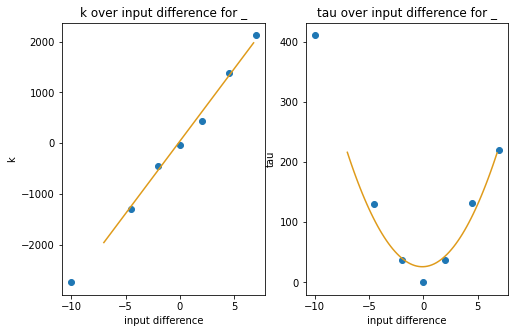

In [22]:
models_1 = train_meta_modell(ex_train, "train on 10")

Our expert stated, that there are quadratic relationships between the outputs and the input so they might reflect on the parameters. The scatter plots suggest a quadratic relationship of tau to the difference and a linear relationship of k to the input difference.

## Prediction with fitted parameters 

In [23]:
def predict_other_experiment(model_parameters, data):
    start = time.time()
    time_splits = get_time_splits(data)
    data_time = data['time']
    data_input = data['input_voltage']
    
    #header = ['spin', 'el', 'th']
    header = ['el']
    durations = []
    
    for i in range(len(header)):
        parameters_k, parameters_tau = model_parameters[i]
        data_value = data[str(header[i] + '_power')]
        
        prm_k = np.empty(3)
        prm_tau = np.empty(3)
        prm_k[0], prm_k[1] = parameters_k
        prm_tau[0], prm_tau[1], prm_tau[2] = parameters_tau

        approximations = np.full(shape = len(data_time), fill_value= np.nan)

        for t in range(len(time_splits) -1):
            cut_point_prior = math.ceil(time_splits[t])
            cut_point_post = math.ceil(time_splits[t+1])
            time_segment = np.array(data_time[cut_point_prior:cut_point_post])
            value_segment = np.array(data_value[cut_point_prior:cut_point_post])
            input_start = data_input[cut_point_prior]
            input_end = data_input[cut_point_post -1]
            input_diff = input_end - input_start

            k = gf.linear_func(input_diff, prm_k[0], prm_k[1])
            tau = gf.quadr_func(input_diff, prm_tau[0], prm_tau[1], prm_tau[2])

            segment_approximation = gf.exp_func(time_segment-time_segment[0], k, tau) + value_segment[0]
            approximations[cut_point_prior:cut_point_post] = segment_approximation

        end = time.time()
        dur = end-start
        durations.append(dur)
        
        data[str(header[i] + '_predictions')] = approximations
    return data, durations

### On seen and unseen experiments

In [24]:
def compare_predictions(experiment, name, model_parameters):
    ex_predicted, durations = predict_other_experiment(model_parameters, experiment)
    
    values = ['spin', 'el', 'th']
    values = ['el']
    for n in values:
        fig, axs = plt.subplots(figsize = (15,10))
        line1, = axs.plot(experiment['time'], experiment[str(n +'_power')], color = gf.get_color('grey'), label = 'true')
        line2, = axs.plot(experiment['time'], experiment[str(n +'_predictions')], color = gf.get_color('green'), label = 'predictions')
        axs.set_title('Validation of ' + n + ' on ' + name, fontsize = 25)
        axs.set_xlabel('time [sec]', fontsize = 18)
        axs.set_ylabel(n , fontsize = 18)
        axs.legend([line1, line2], ['true', 'predictions'], loc = 'upper right')

        fig.savefig(image_folder + name + "_" + n + "_predictions.png")
        fig.savefig(image_folder + name + "_" + n + "_predictions.svg")
        
        print('-------------- Differences on ' + name + ' ' + n + ' predictions ----------------')
        results = gf.measure_difference(experiment[str(n + '_power')], experiment[str(n + '_predictions')])  
        results.to_csv(results_folder + 'experiment{0}.csv'.format(name), sep = "|", encoding="utf-8")

Creation of directory ../Images/Naive_Approach/2021-05-13_08-40/results/ successful.
-------------- Differences on 1 el predictions ----------------
The RMSE is 995.268
The R2-score is 0.028
The MAE is 667.942
The MaxAE is 1985.100
-------------- Differences on 4 el predictions ----------------
The RMSE is 175.209
The R2-score is 0.954
The MAE is 137.513
The MaxAE is 578.361
-------------- Differences on 9 el predictions ----------------
The RMSE is 104.555
The R2-score is 0.932
The MAE is 86.548
The MaxAE is 250.408
-------------- Differences on 20 el predictions ----------------
The RMSE is 121.348
The R2-score is 0.963
The MAE is 99.806
The MaxAE is 407.574
-------------- Differences on 21 el predictions ----------------
The RMSE is 136.453
The R2-score is 0.954
The MAE is 109.318
The MaxAE is 468.567
-------------- Differences on 22 el predictions ----------------
The RMSE is 267.239
The R2-score is 0.887
The MAE is 148.776
The MaxAE is 1142.338
-------------- Differences on 23 el 

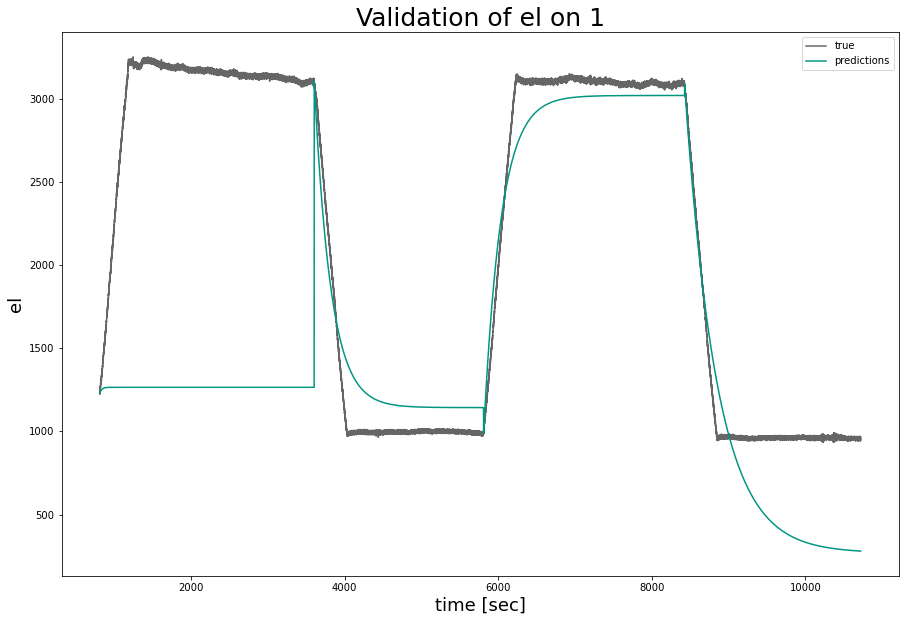

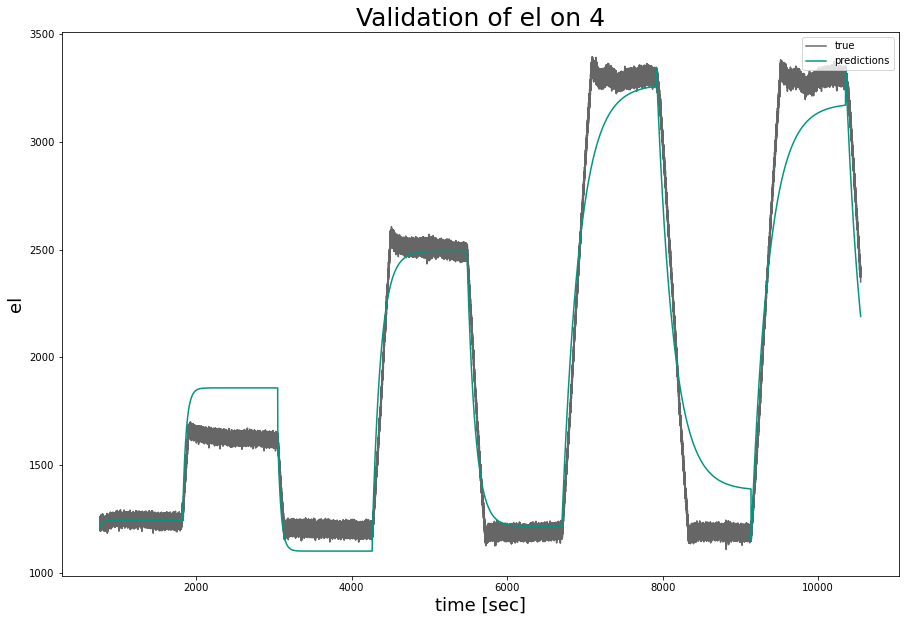

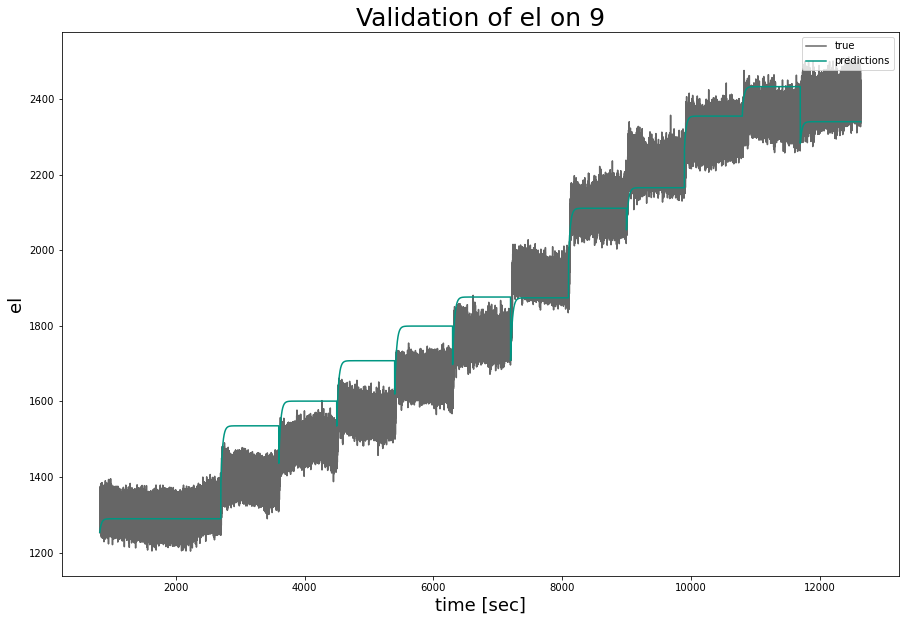

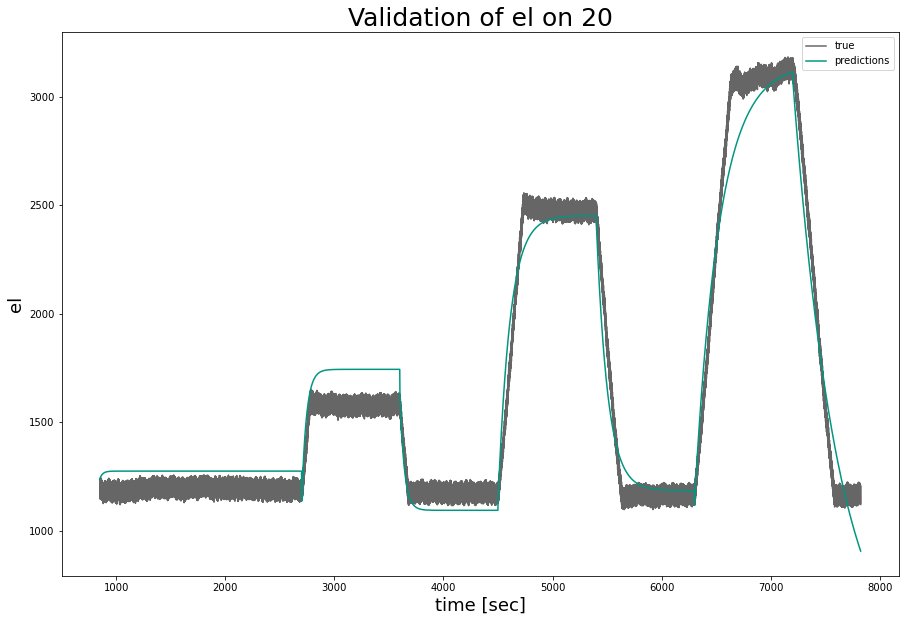

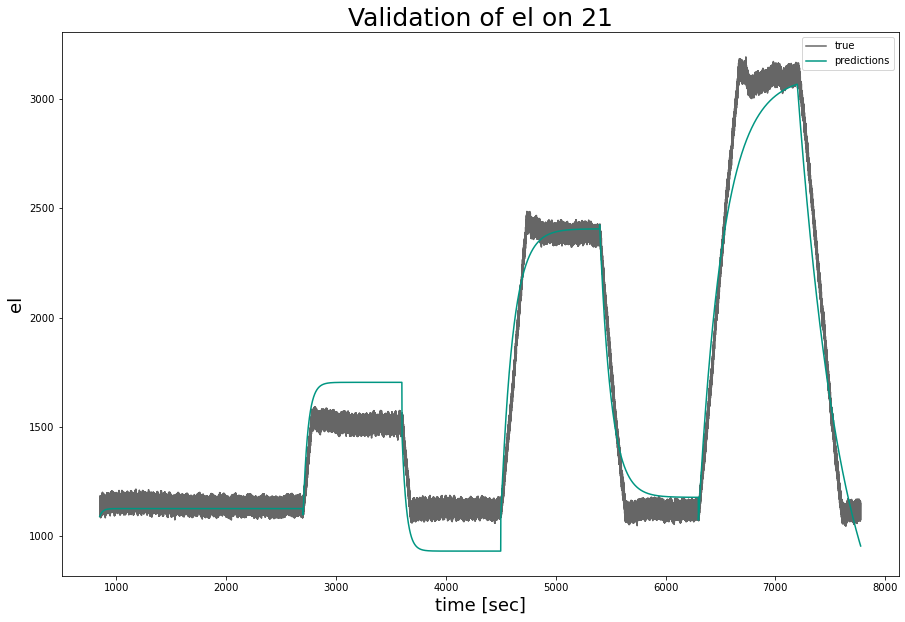

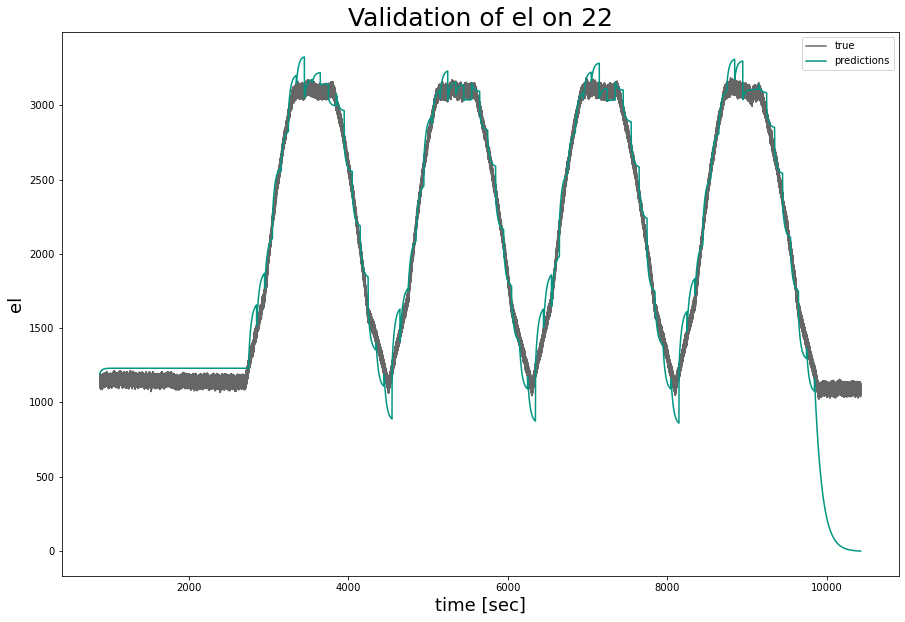

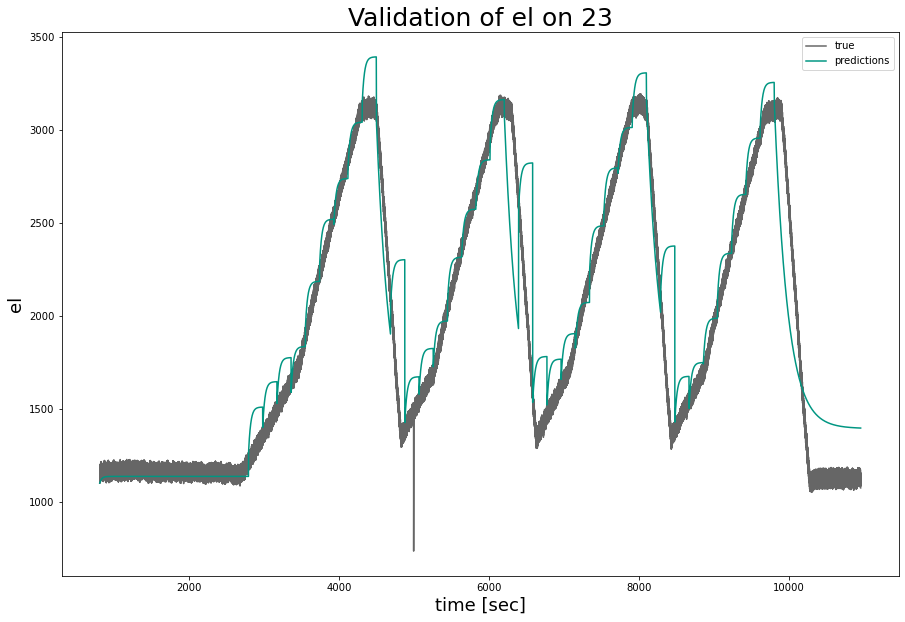

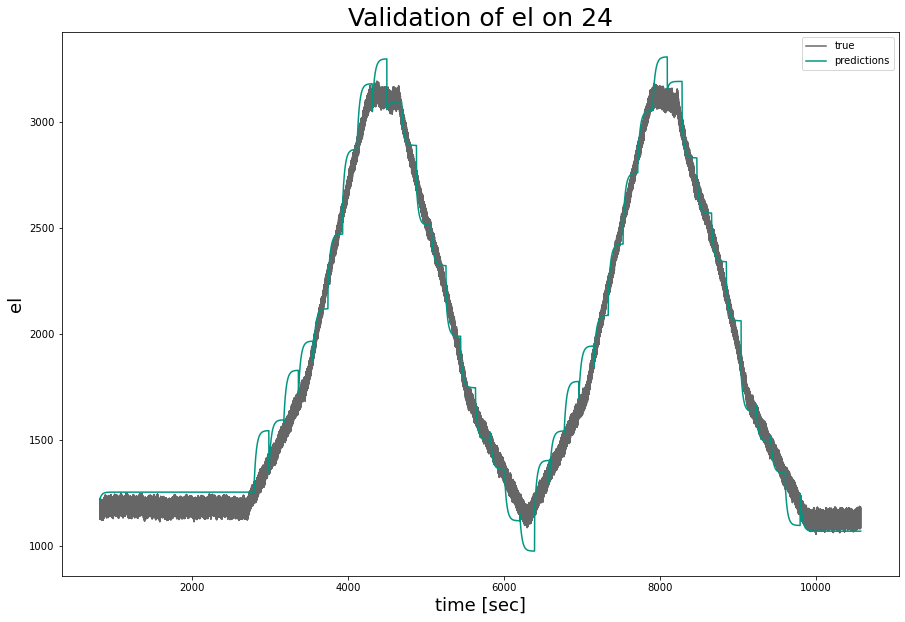

In [25]:
results_folder = image_folder + 'results/'
gf.check_folder(results_folder)
for i in range(len(experiments)):
    compare_predictions(experiments[i], names[i], models_1)

Comparison of predictions using the fits of experiment 4 to true values:

Experiment 1:

Variable|RMSE|R^2|MAX|MaxAE
---|----:|----:|---:|----:
 Spinning  | 1466.611 | -0.559 | 1331.819 | 2182.339
 Electric  | 203.399 | 0.959 | 183.940 | 412.711
 Thermal  | 2190.748 | 0.647 | 1659.354 | 6352.712 

Experiment 9:

Variable|RMSE|R^2|MAE|MaxAE
---|----:|----:|---:|---:
 Spinning  | 25.575 | 0.968 | 19.636 | 53.053 
 Electric  | 101.242 | 0.937 | 82.971 | 285.754 
 Thermal  | 1394.072 | 0.321 | 1111.376 | 3963.333